In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('/content/buzzfeed_headlines.csv')
df.sample(5)

,content,description,title
810,Amritraj Solomon Communications / Via netflix....,"I promise you, this list is gonna work wonders...",These 90s Rom-Coms Will 100% Make Your Life Be...
399,"""I didnt want to participate in prayer or read...",Abuse isn't always physical.View Entire Post ›,Spiritual Abuse Survivors Are Sharing Their St...
871,We hope you love the products we recommend! Al...,"If there are two things I love, it's looking s...",25 Stylish Yet Affordable Things From Boohoo Y...
806,Sign up to the BuzzFeed Quizzes Newsletter - B...,Let them eat all the cake!View Entire Post ›,"Most People Have Tried 7/26 Of These Sweet, So..."
77,"""'We posted it as a manager level position, bu...","""We're a family."" Ugh.View Entire Post ›",Telling You Not To Discuss Your Pay With Cowor...


In [3]:
df.drop(['content', 'description'], axis=1, inplace=True)

In [4]:
!pip install langdetect

     |████████████████████████████████| 981 kB 3.7 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=497e73d10d2e7e7b7b9c896272c025867375d9f5c633ede1128d37210e891e13
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [5]:
from langdetect import detect

In [6]:
def detect_lang(txt):
    try:
        return detect(txt)
    except:
        return np.nan
    
df['language'] = df.title.apply(detect_lang)
df = df[df.language == "en"]
df = df.drop('language', axis=1)

In [7]:
df.isna().sum()

title    0
dtype: int64

In [8]:
df.sample(12)

,title
738,"""The Mentalist"" Actor Simon Baker Has Reported..."
99,If You Have Thoughts About BuzzFeed Shopping C...
873,Here Are 17 Historical Events Most People Were...
827,Adele Says She Doesn’t Want To Do A Major Tour...
119,A Week After 17 People Were Killed In A Bronx ...
773,Emma Thompson Opened Up About The Intense Prep...
797,Harry And Sally? John McLaine And Holly? This ...
197,51 Products Whose Designers Are Truly The Visi...
315,22 Signs That A Restaurant Might Be A Serious ...
712,Jamie Foxx Said He Doesn't Plan On Getting Mar...


In [9]:
# Not going to remove stop words at first to see if the models
# can pick up proper syntax of everything and spit out a 
# headline that looks really similar to real ones rather than 
# headlines with no stop words

# also going to leave the tokenization until later when 
# we do it through TF/Keras
import string

def preprocess(df):
  # stop_words = stopwords.words('english')
  df['title'] = df['title'].str.lower()
  df['title'] = df['title'].str.replace('[^a-zA-Z0-9]', ' ') # replace non-alphanumeric characters with spaces
  df['title'] = df['title'].str.replace('\s+', ' ') # replace multiple spaces with a single space
  df['title'] = df['title'].str.strip() # remove leading and trailing spaces
  # df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

  return df

df = preprocess(df)
df.sample(12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


,title
942,30 things that ll help prevent mess from takin...
568,she became the first latinx woman with a disab...
563,anyone over 28 will relate to this hilariously...
613,jamie lee curtis explained why metoo would hav...
137,laura coates reflected on being snubbed by jeo...
396,if you love ratatouille seeing these 17 disney...
689,nicole kidman is unveiled as lucille ball in t...
302,29 problem solving products any tired college ...
467,23 shocking tv moments that i wish i could go ...
232,these 13 tv and movie writers came clean about...


In [10]:
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku
from tensorflow.random import set_seed
from numpy.random import seed

set_seed(2022)
seed(1)

In [11]:
corpus = [title for title in df['title']]
corpus[:10]

['16 wholesome details from tv and movies that show they were quite literally made with love',
 'jacob elordi has been living the dream filming passionate love scenes with sydney sweeney on euphoria and he knows it',
 'people are sharing things that helped them get a better work life balance and it s so refreshing',
 '7 actors who were considered too ugly for a role and 8 who weren t ugly enough',
 'brian cox says he turned down a role in pirates of the caribbean',
 'eat at this dessert buffet like a toddler at a birthday party and i ll tell you which bsc character you remind me of',
 'directors must really love these 17 pairs of actors together since they keep getting cast as costars',
 'all of the major pop culture happenings this week from celebrity tributes to new trailers',
 'aussies are sharing how their experiences overseas have changed their view on australia and the responses are fascinating',
 'telling you not to discuss your pay with coworkers and 18 other red flags in the w

In [12]:
# Generating Sequence of N-gram Tokens

tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
  # tokenization
  tokenizer.fit_on_texts(corpus)
  total_words = len(tokenizer.word_index) + 1

  # convert data to sequence of tokens
  input_sequences = []
  for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
      n_gram_sequence = token_list[:i+1]
      input_sequences.append(n_gram_sequence)
  return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[122, 412],
 [122, 412, 203],
 [122, 412, 203, 22],
 [122, 412, 203, 22, 74],
 [122, 412, 203, 22, 74, 2],
 [122, 412, 203, 22, 74, 2, 111],
 [122, 412, 203, 22, 74, 2, 111, 7],
 [122, 412, 203, 22, 74, 2, 111, 7, 112],
 [122, 412, 203, 22, 74, 2, 111, 7, 112, 19],
 [122, 412, 203, 22, 74, 2, 111, 7, 112, 19, 52]]

In [13]:
# Padding the Sequences and get predictors & targets/labels

def generate_padded_sequences(input_sequences):
  max_sequence_len = max([len(x) for x in input_sequences])
  input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
  predictors, label = input_sequences[:,:-1], input_sequences[:, -1]
  label = ku.to_categorical(label, num_classes=total_words)
  return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [14]:
from tensorflow.python.keras.utils.data_utils import Sequence
# LSTM model for Text Generation

def create_model(max_sequence_len, total_words):
  input_len = max_sequence_len - 1
  model = Sequential()

  # Input Embedding Layer
  model.add(Embedding(total_words, 10, input_length=input_len))

  # Add a Hidden Layer - LSTM Layer
  model.add(LSTM(100))
  model.add(Dropout(0.2))

  # Add Output Layer
  model.add(Dense(total_words, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam')
  return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 10)            33480     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3348)              338148    
                                                                 
Total params: 416,028
Trainable params: 416,028
Non-trainable params: 0
_________________________________________________________________


In [15]:
# training our model
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
444/444 [==============================] - 12s 13ms/step - loss: 7.0485
Epoch 2/100
444/444 [==============================] - 6s 14ms/step - loss: 6.6528
Epoch 3/100
444/444 [==============================] - 6s 13ms/step - loss: 6.5219
Epoch 4/100
444/444 [==============================] - 6s 13ms/step - loss: 6.3731
Epoch 5/100
444/444 [==============================] - 6s 13ms/step - loss: 6.2137
Epoch 6/100
444/444 [==============================] - 6s 13ms/step - loss: 6.0593
Epoch 7/100
444/444 [==============================] - 6s 13ms/step - loss: 5.9196
Epoch 8/100
444/444 [==============================] - 6s 13ms/step - loss: 5.7822
Epoch 9/100
444/444 [==============================] - 6s 13ms/step - loss: 5.6459
Epoch 10/100
444/444 [==============================] - 6s 13ms/step - loss: 5.5047
Epoch 11/100
444/444 [==============================] - 6s 13ms/step - loss: 5.3661
Epoch 12/100
444/444 [==============================] - 6s 13ms/step - loss: 5.2382


In [16]:
def generate_text(seed_text, next_words, model, max_sequence_len):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list, verbose=0))

    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word

  return seed_text.title()

In [17]:
print(generate_text("21 things", 12, model, max_sequence_len))
print(generate_text("you wouldnt believe", 15, model, max_sequence_len))
print(generate_text("hollywood", 20, model, max_sequence_len))
print(generate_text("coming this year", 10, model, max_sequence_len))
print(generate_text("celebrities", 8, model, max_sequence_len))

21 Things That Ll Help Prevent Mess From The Job Is The House To
You Wouldnt Believe Out On A Tasty Research Study We Ll Stop Laughing These 20 Other Red Flags
Hollywood Of The Best Queer Characters To Appear From Degrassi The Thoughts And I Bet You Re Seen The Movie Of
Coming This Year And The Queen Of Our Hearts Us That They Can
Celebrities Are Sharing The Most Paranormal Thing That Can


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

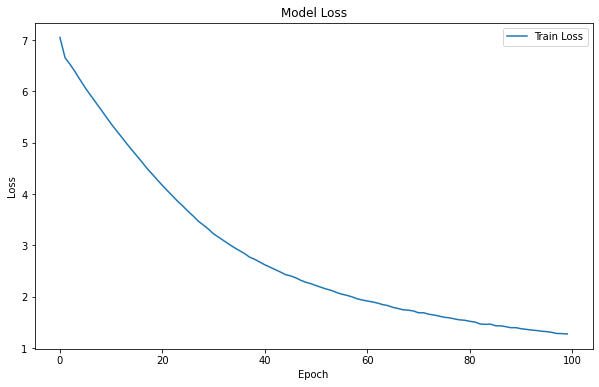

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="Train Loss")
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show();